# Finding Concentration Jacobian(1st Derivative)
What is the partial derivative of the Intensity at each SDD for concentration? Can we find a general solution and then extend it to both the maternal change and the fetal change.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.calculate_intensity import generate_intensity, generate_intensity_column
from tfo_sensitivity.jacobian import calculate_jacobian
import seaborn as sns

plt.style.use('seaborn')

maternal_wall_thickness, uterus_thickness, wave_int = 20, 5, 1
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

In [2]:
plt.rcParams['figure.dpi'] = 150    # Smaller plot
# plt.rcParams['figure.dpi'] = 700    # Paper-ready plots

## Jacobian For saturation
From my derivations,
$$
\frac{\delta I}{\delta S} = -(\epsilon_{Hbo} - \epsilon_{HHb}) \times c \times \sum (L_i I_i)
$$

In [3]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.00001

data_table = pd.DataFrame(
    columns=['Saturation', 'L.I', '|L|', '|I|', 'cosine', 'SDD'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_sat = np.arange(0.1, 0.65, 0.05)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fs in all_fetal_sat:
        # Analytical Expression
        eps_hbo = get_mu_a(1.0, 1, wave_int)
        eps_hhb = get_mu_a(0.0, 1, wave_int)
        modified_mu_map[4] = get_mu_a(fs, FETAL_Hb, wave_int)
        I = generate_intensity_column(
            filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        abs_L = np.linalg.norm(L)
        abs_I = np.linalg.norm(I)
        L_dot_I = np.dot(L, I)
        cosine = L_dot_I / abs_I / abs_L
        # analytical_term = - (eps_hbo - eps_hhb) * FETAL_Hb * np.dot(L, I)

        # Adding to Table
        new_row1 = {'Saturation': fs, 'L.I': L_dot_I, '|L|': abs_L,
                    '|I|': abs_I, 'cosine': cosine, 'SDD': all_sdd[sdd_index]}
        data_table.loc[len(data_table)] = new_row1


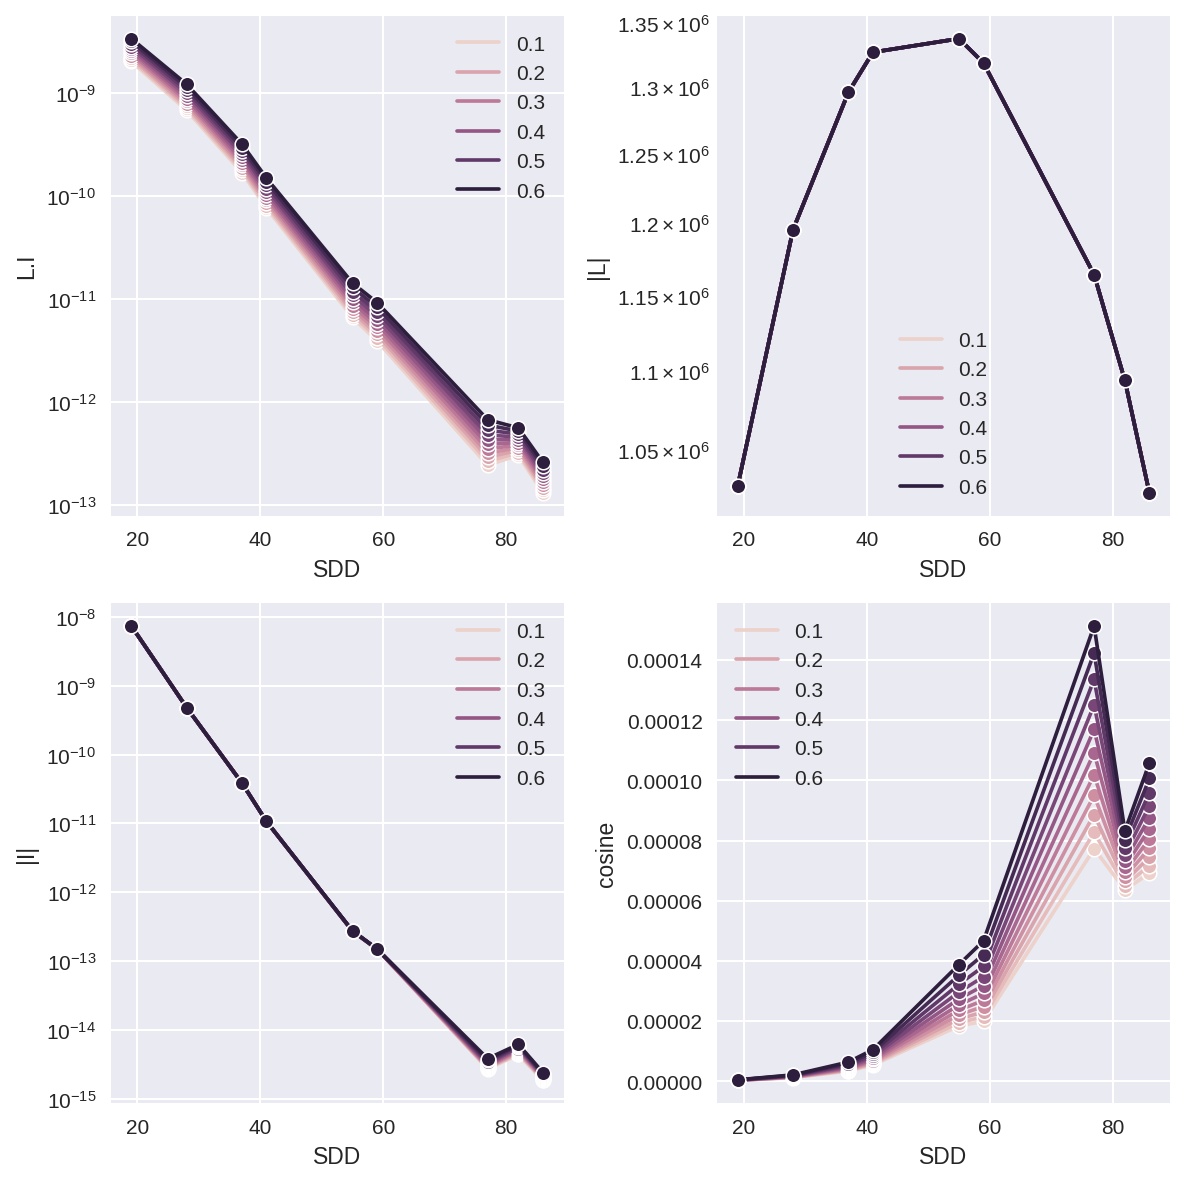

In [4]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
sns.lineplot(data=data_table, x='SDD', y='L.I', hue='Saturation', marker='o')
plt.yscale('log')
plt.legend()
plt.subplot(2, 2, 2)
sns.lineplot(data=data_table, x='SDD', y='|L|', hue='Saturation', marker='o')
plt.yscale('log')
plt.legend()
plt.subplot(2, 2, 3)
sns.lineplot(data=data_table, x='SDD', y='|I|', hue='Saturation', marker='o')
plt.yscale('log')
plt.legend()
plt.subplot(2, 2, 4)
sns.lineplot(data=data_table, x='SDD', y='cosine', hue='Saturation', marker='o')
plt.legend()
plt.tight_layout()

## Jacobian For Concentration
From my derivations,
$$
\frac{\delta I}{\delta c} = -\epsilon \times \sum (L_i I_i)
$$

In [12]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.000001

data_table = pd.DataFrame(columns=['Concentration', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_conc = np.arange(0.1, 0.65, 0.05)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()

modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)


for sdd_index in np.arange(2, 8, 2):
    SDD = all_sdd[sdd_index]
    for fc in all_fetal_conc:
        dI = calculate_jacobian('regular', raw_sim_data, sdd_index, base_mu_map, DELTA, 'FS', all_sdd, MATERNAL_Hb, MATERNAL_SAT, fc, FETAL_SAT, wave_int)\
        
        # Analytical Expression
        eps = get_mu_a(FETAL_SAT, fc, wave_int)
        filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
        modified_mu_map[4] = get_mu_a(FETAL_SAT, fc, wave_int)
        I = generate_intensity_column(filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        analytical_term =  eps * np.dot(L, I)
        
        # Adding to Table
        # Adding to Table
        new_row1 = {'Concentration' : fc, 'Derivative': dI, 'SDD': all_sdd[sdd_index], 'Type': 'Numerical'}
        new_row2 = {'Concentration' : fc, 'Derivative': analytical_term, 'SDD': all_sdd[sdd_index], 'Type': 'Analytical'}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

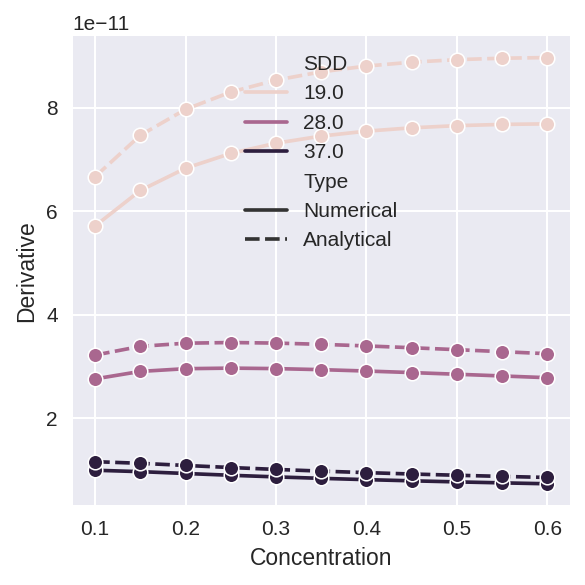

In [11]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=data_table, x='Concentration', y='Derivative', hue='SDD', style='Type', marker='o')
plt.legend()
plt.tight_layout()

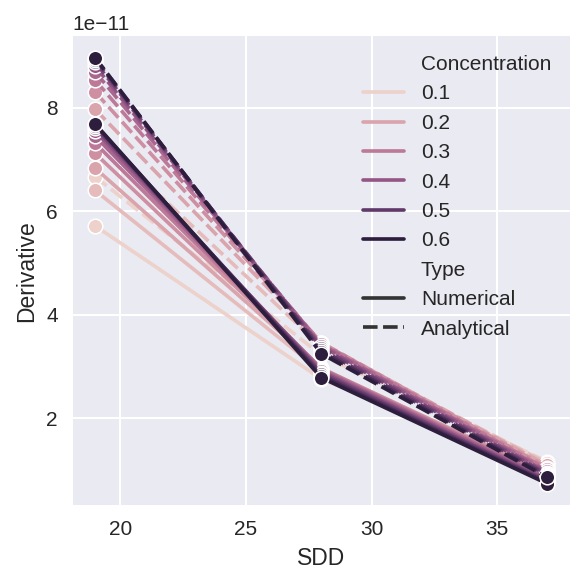

In [13]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Concentration', style='Type', marker='o')
plt.legend()
plt.tight_layout()